####  The aim of this project is to develop a RAG chatboat, which can answer the querries based on latest articles published on European commission news site (written within one month of this project development). For better readability, I have spiltted this project into 3 parts in three different notebooks. Which are following.

1. Web Scrapping part - Web Scrapping.ipynb notebook
2. Chunking & Vectorisation - Chunking&Vectorisation.ipynb
3. Answer Generation - AnswerGeneration.ipynb

In [272]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime, timedelta
from tqdm import tqdm
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import time
from collections import Counter
import re
import matplotlib.pyplot as plt

In [99]:
base_url = "https://commission.europa.eu/news-and-media/news_en"

In [19]:
pagination_nav = soup.find("nav", class_="ecl-pagination")

page_links = []
if pagination_nav:
    for link in pagination_nav.find_all("a", href=True):
        relative = link['href']
        full_url = url + relative
        page_links.append(full_url)

print("Pagination URLs:")
for url in page_links:
    print(url)

Pagination URLs:
https://commission.europa.eu/news-and-media/news_en?page=1
https://commission.europa.eu/news-and-media/news_en?page=2
https://commission.europa.eu/news-and-media/news_en?page=2324
https://commission.europa.eu/news-and-media/news_en?page=1


Here we can see that the site uses querry parameter pagination. So we can directly navigate to the page and retrieve the article metadata.

In [23]:
one_month_ago = datetime.today() - timedelta(days=30)


In [26]:
articles = []  # store filtered articles here

for page_num in range(1, 2325):
    url = f"https://commission.europa.eu/news-and-media/news_en?page={page_num}"
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, "html.parser")

    card_container = soup.find("div", class_="ecl-content-item-block")
    if not card_container:
        break

    cards = card_container.find_all("article", class_="ecl-content-item")

    for card in cards:
        title_tag = card.find("a", class_="ecl-link")
        title = title_tag.text.strip() if title_tag else None
        href = title_tag['href'] if title_tag else None
        full_url = href if href else None

        date_tag = card.find("time")
        date_str = date_tag.text.strip() if date_tag else "N/A"

        # Parse the date
        try:
            article_date = datetime.strptime(date_str, "%d %B %Y")
        except:
            continue  # skip invalid dates

        # Filter: keep if date is within one month
        if article_date >= one_month_ago:
            articles.append({
                "title": title,
                "url": full_url,
                "date": article_date.strftime("%Y-%m-%d")
            })


Append to the list, the first page article's metadata.

In [165]:
url = "https://commission.europa.eu/news-and-media/news_en"
headers = {"User-Agent": "Mozilla/5.0"}

response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.text, "html.parser")

# Find container holding the 10 article cards
article_container = soup.find("div", class_="ecl-content-item-block")

# Find all cards within it
cards = article_container.find_all("article", class_="ecl-content-item")

print(f"Found {len(cards)} articles")

for card in cards:
    link_tag = card.find("a", class_="ecl-link")
    title = link_tag.text.strip() if link_tag else None
    href = link_tag["href"] if link_tag else None

    date_tag = card.find("time")
    date_str = date_tag.text.strip() if date_tag else "N/A"

    print(href)
        # Parse the date
    # try:
    #     article_date = datetime.strptime(date_str, "%d %B %Y")
    # except:
    #     continue  # skip invalid dates

    #     # Filter: keep if date is within one month
    # if article_date >= one_month_ago:
    #         articles.append({
    #             "title": title,
    #             "url": full_url,
    #             "date": article_date.strftime("%Y-%m-%d")
    #         })

Found 0 articles


In [163]:
soup.prettify()

'<!DOCTYPE html>\n<html dir="ltr" lang="en" prefix="og: https://ogp.me/ns#">\n <head>\n  <meta charset="utf-8"/>\n  <meta content="Stay up to the date with news from the Commission\'s departments and services." name="description"/>\n  <meta content="en" http-equiv="content-language"/>\n  <link href="https://commission.europa.eu/news-and-media/news_en" rel="canonical"/>\n  <meta content="follow, noindex" name="robots"/>\n  <meta content="auto" property="og:determiner"/>\n  <meta content="European Commission" property="og:site_name"/>\n  <meta content="website" property="og:type"/>\n  <meta content="https://commission.europa.eu/news-and-media/news_en" property="og:url"/>\n  <meta content="News" property="og:title"/>\n  <meta content="Stay up to the date with news from the Commission\'s departments and services." property="og:description"/>\n  <meta content="https://commission.europa.eu/profiles/contrib/ewcms/modules/ewcms_seo/assets/images/ec-socialmedia-fallback.png" property="og:image"

In [32]:
len(articles)

361

Now we have all the article metadata which have been published under one month from today. Let's save this into a data frame.

In [34]:
metadata = pd.DataFrame(data = articles)

In [109]:
# metadata.to_csv("eu_recent_articles.csv", index=False)
metadata = pd.read_csv("eu_recent_articles.csv")

In [46]:
# After scraping
latest_date = metadata['date'].max()
with open("last_scrape_date.txt", "w") as f:
    f.write(str(latest_date))


# with open("last_scrape_date.txt", "r") as f:
#     last_scrape_date = datetime.strptime(f.read().strip(), "%Y-%m-%d")

Saving the date into the memory. So next time I can scrape the articles published after this date.

In [49]:
article_contents = []  # List to store all article texts

# Loop through metadata URLs
for url in tqdm(metadata['url']):
    try:
        response = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
        soup = BeautifulSoup(response.text, "html.parser")

        # Find all <p> tags
        paragraphs = soup.find_all("p")
        text = " ".join(p.get_text(strip=True) for p in paragraphs)

        
        article_contents.append(text)
    except Exception as e:
        print(f"❌ Failed to fetch {url}: {e}")
        article_contents.append("")  # Append empty if error


  2%|██                                                                                | 9/361 [00:01<01:17,  4.55it/s]

❌ Failed to fetch /news-and-media/news/announcement-next-auction-eu-bonds-14-07-2025-2025-07-09_en: Invalid URL '/news-and-media/news/announcement-next-auction-eu-bonds-14-07-2025-2025-07-09_en': No scheme supplied. Perhaps you meant https:///news-and-media/news/announcement-next-auction-eu-bonds-14-07-2025-2025-07-09_en?


  4%|███▌                                                                             | 16/361 [00:02<01:07,  5.14it/s]

❌ Failed to fetch /news-and-media/news/strengthening-crisis-readiness-and-health-security-2025-07-09_en: Invalid URL '/news-and-media/news/strengthening-crisis-readiness-and-health-security-2025-07-09_en': No scheme supplied. Perhaps you meant https:///news-and-media/news/strengthening-crisis-readiness-and-health-security-2025-07-09_en?


  6%|████▋                                                                            | 21/361 [00:03<00:41,  8.11it/s]

❌ Failed to fetch /news-and-media/news/progress-rule-law-eu-further-action-needed-finds-report-2025-07-08_en: Invalid URL '/news-and-media/news/progress-rule-law-eu-further-action-needed-finds-report-2025-07-08_en': No scheme supplied. Perhaps you meant https:///news-and-media/news/progress-rule-law-eu-further-action-needed-finds-report-2025-07-08_en?


  8%|██████▋                                                                          | 30/361 [00:05<00:49,  6.75it/s]

❌ Failed to fetch /news-and-media/news/progress-rule-law-eu-further-action-needed-finds-report-2025-07-08_en: Invalid URL '/news-and-media/news/progress-rule-law-eu-further-action-needed-finds-report-2025-07-08_en': No scheme supplied. Perhaps you meant https:///news-and-media/news/progress-rule-law-eu-further-action-needed-finds-report-2025-07-08_en?
❌ Failed to fetch /news-and-media/news/plan-stronger-eu-chemical-industry-2025-07-08_en: Invalid URL '/news-and-media/news/plan-stronger-eu-chemical-industry-2025-07-08_en': No scheme supplied. Perhaps you meant https:///news-and-media/news/plan-stronger-eu-chemical-industry-2025-07-08_en?


 23%|██████████████████▊                                                              | 84/361 [00:14<00:30,  9.23it/s]

❌ Failed to fetch /news-and-media/news/results-02-07-2025-auction-eu-bills-2025-07-02_en: Invalid URL '/news-and-media/news/results-02-07-2025-auction-eu-bills-2025-07-02_en': No scheme supplied. Perhaps you meant https:///news-and-media/news/results-02-07-2025-auction-eu-bills-2025-07-02_en?


 24%|███████████████████▎                                                             | 86/361 [00:14<00:35,  7.73it/s]

❌ Failed to fetch /news-and-media/news/making-europe-global-leader-life-sciences-2025-07-02_en: Invalid URL '/news-and-media/news/making-europe-global-leader-life-sciences-2025-07-02_en': No scheme supplied. Perhaps you meant https:///news-and-media/news/making-europe-global-leader-life-sciences-2025-07-02_en?


 28%|██████████████████████▍                                                         | 101/361 [00:17<00:30,  8.63it/s]

❌ Failed to fetch /news-and-media/news/eu-climate-law-new-way-reach-2040-targets-2025-07-02_en: Invalid URL '/news-and-media/news/eu-climate-law-new-way-reach-2040-targets-2025-07-02_en': No scheme supplied. Perhaps you meant https:///news-and-media/news/eu-climate-law-new-way-reach-2040-targets-2025-07-02_en?
❌ Failed to fetch /news-and-media/news/eus-plan-become-global-leader-quantum-2030-2025-07-02_en: Invalid URL '/news-and-media/news/eus-plan-become-global-leader-quantum-2030-2025-07-02_en': No scheme supplied. Perhaps you meant https:///news-and-media/news/eus-plan-become-global-leader-quantum-2030-2025-07-02_en?


 29%|███████████████████████                                                         | 104/361 [00:17<00:24, 10.31it/s]

❌ Failed to fetch /news-and-media/news/eus-plan-become-global-leader-quantum-2030-2025-07-02_en: Invalid URL '/news-and-media/news/eus-plan-become-global-leader-quantum-2030-2025-07-02_en': No scheme supplied. Perhaps you meant https:///news-and-media/news/eus-plan-become-global-leader-quantum-2030-2025-07-02_en?


 30%|███████████████████████▉                                                        | 108/361 [00:17<00:22, 11.19it/s]

❌ Failed to fetch /news-and-media/news/europass-20-years-helping-people-learn-and-work-europe-2025-07-01_en: Invalid URL '/news-and-media/news/europass-20-years-helping-people-learn-and-work-europe-2025-07-01_en': No scheme supplied. Perhaps you meant https:///news-and-media/news/europass-20-years-helping-people-learn-and-work-europe-2025-07-01_en?


 38%|██████████████████████████████▌                                                 | 138/361 [00:22<00:35,  6.23it/s]

❌ Failed to fetch /news-and-media/news/announcement-next-auction-eu-bills-02-07-2025-2025-06-27_en: Invalid URL '/news-and-media/news/announcement-next-auction-eu-bills-02-07-2025-2025-06-27_en': No scheme supplied. Perhaps you meant https:///news-and-media/news/announcement-next-auction-eu-bills-02-07-2025-2025-06-27_en?


 47%|█████████████████████████████████████▉                                          | 171/361 [00:30<00:26,  7.17it/s]

❌ Failed to fetch /news-and-media/news/dg-translation-city-near-you-july-events-2025-06-25_en: Invalid URL '/news-and-media/news/dg-translation-city-near-you-july-events-2025-06-25_en': No scheme supplied. Perhaps you meant https:///news-and-media/news/dg-translation-city-near-you-july-events-2025-06-25_en?


 48%|██████████████████████████████████████▌                                         | 174/361 [00:31<00:25,  7.47it/s]

❌ Failed to fetch /news-and-media/news/eu-space-act-enhancing-market-access-and-space-safety-2025-06-25_en: Invalid URL '/news-and-media/news/eu-space-act-enhancing-market-access-and-space-safety-2025-06-25_en': No scheme supplied. Perhaps you meant https:///news-and-media/news/eu-space-act-enhancing-market-access-and-space-safety-2025-06-25_en?


 57%|█████████████████████████████████████████████▍                                  | 205/361 [00:36<00:16,  9.73it/s]

❌ Failed to fetch /news-and-media/news/results-23-06-2025-auction-eu-bonds-2025-06-23_en: Invalid URL '/news-and-media/news/results-23-06-2025-auction-eu-bonds-2025-06-23_en': No scheme supplied. Perhaps you meant https:///news-and-media/news/results-23-06-2025-auction-eu-bonds-2025-06-23_en?


 68%|██████████████████████████████████████████████████████▎                         | 245/361 [00:43<00:14,  8.04it/s]

❌ Failed to fetch /news-and-media/news/results-18-06-2025-auction-eu-bills-2025-06-18_en: Invalid URL '/news-and-media/news/results-18-06-2025-auction-eu-bills-2025-06-18_en': No scheme supplied. Perhaps you meant https:///news-and-media/news/results-18-06-2025-auction-eu-bills-2025-06-18_en?
❌ Failed to fetch /news-and-media/news/announcement-next-auction-eu-bonds-23-06-2025-2025-06-18_en: Invalid URL '/news-and-media/news/announcement-next-auction-eu-bonds-23-06-2025-2025-06-18_en': No scheme supplied. Perhaps you meant https:///news-and-media/news/announcement-next-auction-eu-bonds-23-06-2025-2025-06-18_en?


 73%|██████████████████████████████████████████████████████████▋                     | 265/361 [00:45<00:07, 13.46it/s]

❌ Failed to fetch /news-and-media/news/commission-proposes-plan-phase-out-russian-gas-and-oil-imports-2025-06-17_en: Invalid URL '/news-and-media/news/commission-proposes-plan-phase-out-russian-gas-and-oil-imports-2025-06-17_en': No scheme supplied. Perhaps you meant https:///news-and-media/news/commission-proposes-plan-phase-out-russian-gas-and-oil-imports-2025-06-17_en?
❌ Failed to fetch /news-and-media/news/new-simplification-proposal-will-speed-defence-investments-eu-2025-06-17_en: Invalid URL '/news-and-media/news/new-simplification-proposal-will-speed-defence-investments-eu-2025-06-17_en': No scheme supplied. Perhaps you meant https:///news-and-media/news/new-simplification-proposal-will-speed-defence-investments-eu-2025-06-17_en?


 77%|█████████████████████████████████████████████████████████████▌                  | 278/361 [00:47<00:10,  7.55it/s]

❌ Failed to fetch /news-and-media/news/state-digital-decade-2025-report-urgent-and-bold-action-needed-2025-06-16_en: Invalid URL '/news-and-media/news/state-digital-decade-2025-report-urgent-and-bold-action-needed-2025-06-16_en': No scheme supplied. Perhaps you meant https:///news-and-media/news/state-digital-decade-2025-report-urgent-and-bold-action-needed-2025-06-16_en?


 81%|████████████████████████████████████████████████████████████████▋               | 292/361 [00:50<00:13,  5.24it/s]

❌ Failed to fetch /news-and-media/news/announcement-next-auction-eu-bills-18-06-2025-2025-06-13_en: Invalid URL '/news-and-media/news/announcement-next-auction-eu-bills-18-06-2025-2025-06-13_en': No scheme supplied. Perhaps you meant https:///news-and-media/news/announcement-next-auction-eu-bills-18-06-2025-2025-06-13_en?


 91%|████████████████████████████████████████████████████████████████████████▉       | 329/361 [00:57<00:08,  3.88it/s]

❌ Failed to fetch /news-and-media/news/commission-adopts-ocean-pact-eu1-billion-protect-marine-life-and-strengthen-blue-economy-2025-06-11_en: Invalid URL '/news-and-media/news/commission-adopts-ocean-pact-eu1-billion-protect-marine-life-and-strengthen-blue-economy-2025-06-11_en': No scheme supplied. Perhaps you meant https:///news-and-media/news/commission-adopts-ocean-pact-eu1-billion-protect-marine-life-and-strengthen-blue-economy-2025-06-11_en?


100%|████████████████████████████████████████████████████████████████████████████████| 361/361 [01:05<00:00,  5.48it/s]


In [68]:
article_contents[6]

"The European Commission has today launched acall for applicationsfor members of the thirdPlatform on Sustainable Finance. The platform is an advisory body composed of experts from the private and public sector. Its role is to advise the Commission on relevant topics related to theEU\xa0taxonomyand theEU\xa0sustainable finance frameworkat\xa0large. As part of its February\xa02025Omnibus package, the Commission announced a review of the existing technical screening criteria of theTaxonomy Climate and Environmental Delegated Actsto improve their usability and coherence. The third Platform on Sustainable Finance will be consulted for this review and provide advice to the Commission on the development of criteria for economic activities that could be added to the taxonomy. In addition, the platform will support the Commission’s ongoing work on transition finance, helping to ensure that EU policies effectively guide and accelerate the shift toward a\xa0more\xa0sustainable\xa0economy. The ne

In [71]:
metadata['url'][7]

'https://competition-policy.ec.europa.eu/about/news/commission-provides-guidance-creation-licensing-negotiation-group-automotive-sector-licensing-2025-07-09_en'

I think the scrapping for few pages failed because of the JS code,it takes time in loading. Let's set a waiting time for three sec and then scrape. Let's see if this works.


In [ ]:

# Set up headless Chrome
options = Options()
options.add_argument("--headless")
options.add_argument("--disable-gpu")
options.add_argument("--no-sandbox")

driver = webdriver.Chrome(options=options)

article_contents = []

# Loop over all metadata URLs
for url in tqdm(metadata['url']):
    try:
        driver.get(url)
        time.sleep(3)  # wait for JS to fully render the page

        # Get full HTML after JS execution
        soup = BeautifulSoup(driver.page_source, "html.parser")

        # Extract <p> tags
        paragraphs = [p.get_text(strip=True) for p in soup.find_all("p")]
        article_contents.append(paragraphs)  # as list of lists

    except Exception as e:
        print(f" Error fetching {url}: {e}")
        article_contents.append([])

driver.quit()


In [111]:
metadata['url'][5]

'https://civil-protection-humanitarian-aid.ec.europa.eu/news-stories/news/eu-stockpiling-and-medical-countermeasures-strategies-strengthen-crisis-readiness-and-health-2025-07-09_en'

In [113]:
metadata['url'][9]

'https://commission.europa.eu/news-and-media/news/announcement-next-auction-eu-bonds-14-07-2025-2025-07-09_en'

In [ ]:
https://commission.europa.eu/news-and-media/news/announcement-next-auction-eu-bonds-14-07-2025-2025-07-09_en

In [ ]:
https://commission.europa.eu/news-and-media/news/strengthening-crisis-readiness-and-health-security-2025-07-09_en

In [119]:
empty_indices = [i for i, item in enumerate(article_contents) if len(item) == 0]

empty_indices

[361, 362]

In [112]:
start = "https://commission.europa.eu"

for i in empty_indices:
    url = metadata['url'][i]
    if not url.startswith("/"):
        url = "/" + url
    metadata['url'][i] = start + url


C:\Users\shri\AppData\Local\Temp\ipykernel_27628\1442694211.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  metadata['url'][i] = start + url


In [118]:
options = Options()
options.add_argument("--headless")
options.add_argument("--disable-gpu")
options.add_argument("--no-sandbox")

driver = webdriver.Chrome(options=options)
for i in tqdm(empty_indices):
    url = metadata['url'][i]
    try:
        driver.get(url)
        time.sleep(3)  # wait for JS to fully render the page

        # Get full HTML after JS execution
        soup = BeautifulSoup(driver.page_source, "html.parser")

        # Extract <p> tags
        paragraphs = [p.get_text(strip=True) for p in soup.find_all("p")]
        # article_contents.append(paragraphs)  # as list of lists
        article_contents[i] = paragraphs

    except Exception as e:
        print(f" Error fetching {url}: {e}")
        article_contents.append([])


driver.quit()

100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:19<00:00,  3.62s/it]


In [121]:
metadata

(361, 3)

In [123]:
metadata['url'][360]

'https://oceans-and-fisheries.ec.europa.eu/news/commissioner-kadis-la-reunion-open-29th-indian-ocean-tuna-commission-meeting-2025-04-11_en'

In [125]:
article_contents[360]

['This site uses cookies. Visit ourcookies policy pageor click the link in any footer for more information and to change your preferences.',
 'All official European Union website addresses are in theeuropa.eudomain.',
 'See all EU institutions and bodies',
 'On 13 April, Commissioner Kadis will officially open the 29th annual meeting of theIndian Ocean Tuna Commission (IOTC), which\xa0plays a crucial role in overseeing the conservation of tuna and tuna-like species. The meeting, hosted\xa0by the EU in La Réunion and opened together with\xa0Agnès Pannier-Runacher, French Minister for the Ecological Transition, Biodiversity, Forests, Marine Affairs and Fisheries, will take place from 13 to 17 April 2025.',
 'The IOTC\xa0promotes cooperation for the conservation and optimal utilisation of the tuna stocks in the Indian Ocean and to ensure the establishment of sustainable fisheries in the region. To achieve these objectives,IOTC members, including the EU, meet annually, discuss and adopt me

In [152]:
article_contents[355]

['This site uses cookies. Visit ourcookies policy pageor click the link in any footer for more information and to change your preferences.',
 'All official European Union website addresses are in theeuropa.eudomain.',
 'See all EU institutions and bodies',
 'On 13 April, Commissioner Kadis will officially open the 29th annual meeting of theIndian Ocean Tuna Commission (IOTC), which\xa0plays a crucial role in overseeing the conservation of tuna and tuna-like species. The meeting, hosted\xa0by the EU in La Réunion and opened together with\xa0Agnès Pannier-Runacher, French Minister for the Ecological Transition, Biodiversity, Forests, Marine Affairs and Fisheries, will take place from 13 to 17 April 2025.',
 'The IOTC\xa0promotes cooperation for the conservation and optimal utilisation of the tuna stocks in the Indian Ocean and to ensure the establishment of sustainable fisheries in the region. To achieve these objectives,IOTC members, including the EU, meet annually, discuss and adopt me

In [153]:
metadata['url'][354]

'https://oceans-and-fisheries.ec.europa.eu/news/commissioner-kadis-la-reunion-open-29th-indian-ocean-tuna-commission-meeting-2025-04-11_en'

Saving the contents into the df

In [126]:
metadata['text'] = article_contents[:361]

In [129]:
metadata.to_csv("eu_recent_articles.csv", index=False)

I saw that the last 10 links are same in the metadata and lets see why are the links same

In [159]:
date = max(metadata['date'])

In [171]:
one_month_ago = datetime.today() - timedelta(days=30)

In [182]:
headers = {"User-Agent": "Mozilla/5.0"}
articles = []
one_month_ago = datetime.today() - timedelta(days=30)

# Looping through pages
for page_num in range(0, 2327):  
    url = f"https://commission.europa.eu/news-and-media/news_en?page={page_num}"
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, "html.parser")

    cards = soup.find_all("article", class_="ecl-content-item")

    print(f"Page {page_num}: Found {len(cards)} articles")

    for card in cards:
        link_tag = card.find("a", class_="ecl-link")
        title = link_tag.text.strip() if link_tag else None
        href = link_tag["href"] if link_tag else None
        full_url = f"https://commission.europa.eu{href}" if href and href.startswith("/") else href

        date_tag = card.find("time")
        date_str = date_tag.text.strip() if date_tag else "N/A"
        # print(f" → {date_str}")

        try:
            article_date = datetime.strptime(date_str, "%d %B %Y")
        except:
            continue  # skip invalid dates


        if article_date < one_month_ago:
            print(f"Stopping at page {page_num} — found article from {article_date.strftime('%Y-%m-%d')}")
            break

        articles.append({
            "title": title,
            "url": full_url,
            "date": article_date.strftime("%Y-%m-%d")
        })

    else:
        continue  # continue outer loop only if inner loop wasn't broken
    break  # outer loop break

print(f"\n Total recent articles collected: {len(articles)}")


Page 0: Found 11 articles
Page 1: Found 11 articles
Page 2: Found 11 articles
Page 3: Found 11 articles
Page 4: Found 11 articles
Page 5: Found 11 articles
Page 6: Found 11 articles
Page 7: Found 11 articles
Page 8: Found 11 articles
Page 9: Found 11 articles
Page 10: Found 11 articles
Page 11: Found 11 articles
Page 12: Found 11 articles
Page 13: Found 11 articles
Page 14: Found 10 articles
Page 15: Found 11 articles
Page 16: Found 10 articles
Page 17: Found 11 articles
Page 18: Found 11 articles
Page 19: Found 11 articles
Page 20: Found 11 articles
Page 21: Found 11 articles
Page 22: Found 11 articles
Page 23: Found 11 articles
Page 24: Found 11 articles
Page 25: Found 10 articles
Page 26: Found 11 articles
Page 27: Found 11 articles
Page 28: Found 11 articles
Page 29: Found 11 articles
Page 30: Found 11 articles
Page 31: Found 11 articles
Page 32: Found 11 articles
Page 33: Found 11 articles
Page 34: Found 11 articles
Page 35: Found 11 articles
Page 36: Found 11 articles
Stopping at

In [183]:
articles

[{'title': 'Microfinance in Europe: Survey report 2024',
  'url': 'https://social-economy-gateway.ec.europa.eu/microfinance-europe-survey-report-2024-2025-07-14_en',
  'date': '2025-07-14'},
 {'title': 'AccessibleEU surpassed all its objectives last year, as reported in the 2024 Final Report',
  'url': 'https://accessible-eu-centre.ec.europa.eu/content-corner/news/accessibleeu-surpassed-all-its-objectives-last-year-reported-2024-final-report-2025-07-14_en',
  'date': '2025-07-14'},
 {'title': 'EU invests 2.8 billion in 94 transport projects to boost sustainable and connected mobility across Europe',
  'url': 'https://urban-mobility-observatory.transport.ec.europa.eu/news-events/news/eu-invests-28-billion-94-transport-projects-boost-sustainable-and-connected-mobility-across-europe-2025-07-11_en',
  'date': '2025-07-11'},
 {'title': 'Hamburg deploys AI to boost efficiency of electric ferry fleet',
  'url': 'https://urban-mobility-observatory.transport.ec.europa.eu/news-events/news/hambur

In [184]:
metadata_2 = pd.DataFrame(data = articles)

In [188]:
metadata_2.to_csv("metadata_second.csv" , index = False)

In [193]:
metadata = metadata[:-10]

In [194]:
metadata.tail()

,title,url,date,text
346,The European Commission participated in the se...,https://research-and-innovation.ec.europa.eu/n...,2025-06-11,[This site uses cookies. Visit ourcookies poli...
347,The European Commission participated in the se...,https://research-and-innovation.ec.europa.eu/n...,2025-06-11,[This site uses cookies. Visit ourcookies poli...
348,Pact on Migration and Asylum: Commission repor...,https://home-affairs.ec.europa.eu/news/pact-mi...,2025-06-11,[This site uses cookies. Visit ourcookies poli...
349,Commissioner Jørgensen hosts high-level implem...,https://energy.ec.europa.eu/news/commissioner-...,2025-06-11,[This site uses cookies. Visit ourcookies poli...
350,Energy production must be more inclusive and a...,https://www.eesc.europa.eu/en/news-media/press...,2025-06-11,[All official European Union website addresses...


Merging the two dataframes

In [195]:
# Merging metadata_2 with metadata to bring in the 'text' column
metadata_2 = metadata_2.merge(
    metadata[['title', 'url', 'date', 'text']],  # only keeping relevant columns
    on=['title', 'url', 'date'],  # joining on these 3 columns
    how='left'  # keeping all rows from metadata_2
)


In [204]:
metadata_2['text'].isna().sum()


0

In [205]:
metadata_2.to_csv("metadata_second.csv" , index = False)

In [203]:
metadata_2.shape

(404, 4)

In [200]:
empty_indices = metadata_2[metadata_2['text'].isna()].index

# storing newly scraped text
scraped_texts = {}

options = Options()
options.add_argument("--headless")
options.add_argument("--disable-gpu")
options.add_argument("--no-sandbox")

driver = webdriver.Chrome(options=options)

for i in tqdm(empty_indices):
    url = metadata_2.loc[i, 'url']
    try:
        driver.get(url)
        time.sleep(3) 

        # Parsing rendered HTML
        soup = BeautifulSoup(driver.page_source, "html.parser")

        # all paragraph text
        paragraphs = [p.get_text(strip=True) for p in soup.find_all("p")]
        full_text = "\n".join(paragraphs)

        scraped_texts[i] = full_text

    except Exception as e:
        print(f" Error fetching {url}: {e}")
        scraped_texts[i] = None

driver.quit()


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [03:48<00:00,  3.87s/it]


In [201]:
scraped_texts

{0: 'This site uses cookies. Visit ourcookies policy pageor click the link in any footer for more information and to change your preferences.\nAll official European Union website addresses are in theeuropa.eudomain.\nSee all EU institutions and bodies\nThe European Microfinance Network (EMN) and the Microfinance Centre (MFC) are pleased to present the12th editionof their flagship publication:Microfinance in Europe: Survey Report. This long-standing survey remains the leading source of data and analysis on the microfinance sector in Europe.\nFor thesixth consecutive survey edition, EMN and MFC have joined forces to capture data from the vast majority of European microfinance institutions, providing the most comprehensivedatasetavailable on the sector today.\nThis edition focuses on thetypes of businesses reached by microfinanceand highlights thesocial performance of business loans, along with theimpact measurement approachesadopted by MFIs. It offers valuable insights into how these ins

In [202]:
for idx, text in scraped_texts.items():
    metadata_2.at[idx, 'text'] = text


Now I have all the metadata with article's body.

Next Steps:
1. Remove coockies part from the article body.
2. Split the text part into chuncks of 500 (or whatever suitable) with overlapping to some extents.
3. Calculatte the embeddings for the chuncks and store in the vector database with reference to the metadata(means a single article has multiple chuncks stored at the concurrent indexes). 
3. Try retrieving the similar chunks for a sample question and give it to the LLM for answer generation and evaluate the performance.


Let's have a look at the metadata text.

In [211]:
metadata_2['text'][1]

'This site uses cookies. Visit ourcookies policy pageor click the link in any footer for more information and to change your preferences.\nAll official European Union website addresses are in theeuropa.eudomain.\nSee all EU institutions and bodies\nThis report provides a comprehensive overview of the actions undertaken during AccessibleEU’s second year contract, highlighting main achievements, the completion of major milestones, and the valuable lessons learned for the coming years.\nAccessibleEU surpassed all its yearly objectives in 2024, as evidenced in the newly publishedAccessibleEU Final Report 2024 Executive Summary. The initiative saw a significant progress in bringing together policy makers, experts and persons with disabilities, as well as in providing guidance for the implementation of accessibility standards via training, awareness-raising, and technical publications.\nOne of the key achievements in 2024 was the refinement and implementation of the set of indicators monitor

In [212]:
metadata_2['text'][2]

"This site uses cookies. Visit ourcookies policy pageor click the link in any footer for more information and to change your preferences.\nAll official European Union website addresses are in theeuropa.eudomain.\nSee all EU institutions and bodies\nOn the 3 July 2025, the European Commission announced 94 transport projects across the EU that will receive nearly €2.8 billion in EU grants under the Connecting Europe Facility (CEF).\nBy modernising railways, inland waterways and maritime routes across the trans-European transport network (TEN-T), the projects will not only help better connect European regions and cities – north to south, east to west - but will also strengethen the EU’s internal market by making it more competitive and resilient.\nThe following eight projects illustrate how EU funding is helping to modernise transport infrastructure inurban nodes -expanding smarter, safer and more sustainable transport networks across Europe.\nThis project involves the design of an access

In [213]:
metadata_2['text'][400]

['This site uses cookies. Visit ourcookies policy pageor click the link in any footer for more information and to change your preferences.',
 'All official European Union website addresses are in theeuropa.eudomain.',
 'See all EU institutions and bodies',
 'The European Commission has today adopted a delegated act that postpones by one additional year - until 1 January 2027 - the date of application of the one remaining part of the Basel III international standards in the EU – the Fundamental Review of the Trading Book (FRTB). The FRTB aims to introduce more sophisticated risk measurement techniques, allowing for a closer alignment between capital charges and the actual risks banks are facing in their\xa0capital\xa0markets activities.',
 'The application of the Basel standards is important for a resilient EU banking sector and to safeguard global financial stability. The Commission has always been committed to a timely implementation of the Basel III standards. As a matter of fact, mo

In [214]:
metadata_2['text'][350]

'This site uses cookies. Visit ourcookies policy pageor click the link in any footer for more information and to change your preferences.\nAll official European Union website addresses are in theeuropa.eudomain.\nSee all EU institutions and bodies\nToday, the Commission proposes to integrate Ukraine into the EU Roaming area as from January 2026. This will enable Ukrainians to call, text and use their mobile data from Ukrainian phone numbers in the 27 EU countries at no extra cost, and extend the same benefits to Europeans who may be in Ukraine.\nCommission Presidentvon der Leyensaid: “We want Ukrainian citizens to stay connected to their loved ones across the EU, as well as in their home country. That’s why we propose that Ukraine join our roaming family. Once more, we reaffirm our continued commitment to stand by Ukraine and its citizens.”\nRoaming is the first area where the EU would extend internal market treatment to Ukraine.\nThe Commission has sent the proposal adopted today to t

It seems that the text starts and ends with some website information. Let's verify below.

In [241]:
metadata_2['text'] = metadata_2['text'].apply(
    lambda x: "\n".join(x) if isinstance(x, list) else x
)

In [242]:
texts = metadata_2['text'].astype(str)


# Get first and last 200 characters from each article
starts = [text[:200] for text in texts]
ends = [text[-50:] for text in texts]

# Count frequency of repeated starting/ending patterns
start_counts = Counter(starts)
end_counts = Counter(ends)

# Show most common patterns
print("🔹 Most common starting phrases:")
for s, c in start_counts.most_common(5):
    print(f"({c} times)\n{s}\n")

print("\n🔹 Most common ending phrases:")
for e, c in end_counts.most_common(5):
    print(f"({c} times)\n{e}\n")

🔹 Most common starting phrases:
(345 times)
This site uses cookies. Visit ourcookies policy pageor click the link in any footer for more information and to change your preferences.
All official European Union website addresses are in theeuropa.

(43 times)
All official European Union website addresses are in theeuropa.eudomain.
See all EU institutions and bodies
This site uses cookies. Visit ourcookies policy pageor click the link in any footer for more

(4 times)
All official European Union website addresses are in theeuropa.eudomain.
Press releasePublished 20 Jun 2025
From Europe’s coastal waters to its inland bathing sites, a large majority of Europe’s water

(2 times)
All official European Union website addresses are in theeuropa.eudomain.
Press releasePublished 26 Jun 2025
Scaling up renewable electricity sources across the EU could reduce electricity generation c

(2 times)
All official European Union website addresses are in theeuropa.eudomain.
Press releasePublished 24 Jun 2025

It appears that all the texts begin with the same three introductory lines and end with the same two closing lines. Only the phrasing and syntax in between differ slightly.
1. This site uses cookies.
2. Visit ourcookies policy pageor click the link in any footer for more information and to change your preferences.
3. All official European Union website addresses are in theeuropa.eudomain.
4. See all EU institutions and bodies.

Footer
1. Share this page
2. Follow us

In [249]:
boilerplate_sentences = [
    "This site uses cookies.",
    "Visit ourcookies policy pageor click the link in any footer for more information and to change your preferences.",
    "All official European Union website addresses are in theeuropa.eudomain.",
    "See all EU institutions and bodies",
    "Share this page",
    "Follow us",
    "Follow the European Commission"
]


In [250]:
def clean_sentences(text):
    if not isinstance(text, str):
        return text

    # Split into sentences (naive split on period and newline)
    sentences = re.split(r'(?<=[.!?])\s+|\n+', text.strip())

    # Cleaned version: keep only if not in boilerplate
    cleaned = [s for s in sentences if s.strip() not in boilerplate_sentences]

    return " ".join(cleaned).strip()


In [251]:
clean_texts = metadata_2['text'].apply(clean_sentences)


In [252]:
clean_texts[350]

'Today, the Commission proposes to integrate Ukraine into the EU Roaming area as from January 2026. This will enable Ukrainians to call, text and use their mobile data from Ukrainian phone numbers in the 27 EU countries at no extra cost, and extend the same benefits to Europeans who may be in Ukraine. Commission Presidentvon der Leyensaid: “We want Ukrainian citizens to stay connected to their loved ones across the EU, as well as in their home country. That’s why we propose that Ukraine join our roaming family. Once more, we reaffirm our continued commitment to stand by Ukraine and its citizens.” Roaming is the first area where the EU would extend internal market treatment to Ukraine. The Commission has sent the proposal adopted today to the Council for its approval. More information is available in apress releaseonline. (For more information: Thomas Regnier - Tel.: +32 2 29 91099; Patricia Poropat - Tel.: +32 2 29 80485)'

In [253]:
clean_texts[1]

'This report provides a comprehensive overview of the actions undertaken during AccessibleEU’s second year contract, highlighting main achievements, the completion of major milestones, and the valuable lessons learned for the coming years. AccessibleEU surpassed all its yearly objectives in 2024, as evidenced in the newly publishedAccessibleEU Final Report 2024 Executive Summary. The initiative saw a significant progress in bringing together policy makers, experts and persons with disabilities, as well as in providing guidance for the implementation of accessibility standards via training, awareness-raising, and technical publications. One of the key achievements in 2024 was the refinement and implementation of the set of indicators monitoring accessibility initiatives across all Member States. A large amount of information was collected to monitor commitments and efforts made by each Member States to implement accessibility legislation and standards, which can be consulted on the webs

In [254]:
clean_texts[300]

'Today the European Commission countered the circumvention of anti-dumping measures on imports of graphite electrode systems from China by extending their application to imports of artificial graphite in blocks or cylinders. Graphite is a critical material for helping the EU to achieve its digital and green technology transitions. The level of duty to be applied on imports of artificial graphite from China is 74.9%. The application of the anti-dumping measures is being extended following a Commission investigation, which found that the measures applied to graphite electrode systems (GES) from China were being circumvented by imports of artificial graphite – the main input material – from China into the EU. The artificial graphite was then further processed into GES. Little economic justification was found for this practice other than the avoidance of anti-dumping duties on imports of GES from China. The extension only applies to artificial graphite that is used to produce GES. Hard blo

In [255]:
clean_texts[400]

'The European Commission has today adopted a delegated act that postpones by one additional year - until 1 January 2027 - the date of application of the one remaining part of the Basel III international standards in the EU – the Fundamental Review of the Trading Book (FRTB). The FRTB aims to introduce more sophisticated risk measurement techniques, allowing for a closer alignment between capital charges and the actual risks banks are facing in their\xa0capital\xa0markets activities. The application of the Basel standards is important for a resilient EU banking sector and to safeguard global financial stability. The Commission has always been committed to a timely implementation of the Basel III standards. As a matter of fact, most of the Basel III requirements entered into force on 1 January 2025 thanks to the 2024 Banking package. As regards the FRTB, the Banking package includes the possibility for the Commission to postpone the entry into force of the FRTB or to amend it, for a time

let's check once again

In [256]:
metadata_2['text'][400]

'This site uses cookies. Visit ourcookies policy pageor click the link in any footer for more information and to change your preferences.\nAll official European Union website addresses are in theeuropa.eudomain.\nSee all EU institutions and bodies\nThe European Commission has today adopted a delegated act that postpones by one additional year - until 1 January 2027 - the date of application of the one remaining part of the Basel III international standards in the EU – the Fundamental Review of the Trading Book (FRTB). The FRTB aims to introduce more sophisticated risk measurement techniques, allowing for a closer alignment between capital charges and the actual risks banks are facing in their\xa0capital\xa0markets activities.\nThe application of the Basel standards is important for a resilient EU banking sector and to safeguard global financial stability. The Commission has always been committed to a timely implementation of the Basel III standards. As a matter of fact, most of the Bas

Let's check once again if there are any common terms

In [257]:
texts_2 = clean_texts.astype(str)

starts = [text[:200] for text in texts_2]
ends = [text[-50:] for text in texts_2]

start_counts = Counter(starts)
end_counts = Counter(ends)

print("🔹 Most common starting phrases:")
for s, c in start_counts.most_common(5):
    print(f"({c} times)\n{s}\n")

print("\n🔹 Most common ending phrases:")
for e, c in end_counts.most_common(5):
    print(f"({c} times)\n{e}\n")

🔹 Most common starting phrases:
(6 times)
Disclaimer This is a machine translation provided by the European Commission’s eTranslation service to help you understand this page.Please read the conditions of use. Select language below Accept and

(5 times)
Today, the European Commission announced that it will, on behalf of the European Union, auction the following securities: * in millions of euros Members of the EU Primary Dealer Network are entitled t

(4 times)
On 18 June, the EU Anti-Trafficking Coordinator, Diane Schmitt, and the Inter-Agency Coordination Group against Trafficking in Persons (ICAT), which was mandated by the UN General Assembly, discussed 

(4 times)
The initiative will provide a common methodology for calculating, verifying and reporting on recycled plastic content in single-use beverage bottles. The European Commission has launched apublic consu

(4 times)
The rule of law is the cornerstone of our democracies. It is also integral for the future of our economies and

Now they seems to be genuine strings. Let's replace the text with cleaned texts in our data frame.

In [260]:
metadata_2['text'] = clean_texts

In [261]:
metadata_2.to_csv("cleaned_metadata.csv" , index = False)

Now the text is cleaned and saved into disk. Now the next step should be creating chunks and vectorisation

In [262]:
metadata_2.head(5)

,title,url,date,text
0,Microfinance in Europe: Survey report 2024,https://social-economy-gateway.ec.europa.eu/mi...,2025-07-14,The European Microfinance Network (EMN) and th...
1,AccessibleEU surpassed all its objectives last...,https://accessible-eu-centre.ec.europa.eu/cont...,2025-07-14,This report provides a comprehensive overview ...
2,EU invests 2.8 billion in 94 transport project...,https://urban-mobility-observatory.transport.e...,2025-07-11,"On the 3 July 2025, the European Commission an..."
3,Hamburg deploys AI to boost efficiency of elec...,https://urban-mobility-observatory.transport.e...,2025-07-11,"Hadag, the operator of Hamburg’s ferry service..."
4,Israel/Palestine: Statement by the High Repres...,https://north-africa-middle-east-gulf.ec.europ...,2025-07-11,Following the Israeli Cabinet’s resolutions an...


Let's do some analysis on the text.

In [264]:
word_counts = []
#  word counts
word_counts = metadata_2['text'].apply(lambda x: len(str(x).split()))

#  Mean word count
mean_words = word_counts.mean()

# shortest and longest articles
min_idx = word_counts.idxmin()
max_idx = word_counts.idxmax()

shortest_article = metadata_2.loc[min_idx]
longest_article = metadata_2.loc[max_idx]

In [271]:
mean_words

442.86386138613864

C:\Users\shri\AppData\Local\Temp\ipykernel_27628\1910769456.py:16: UserWarning: Glyph 128218 (\N{BOOKS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\shri\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128218 (\N{BOOKS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


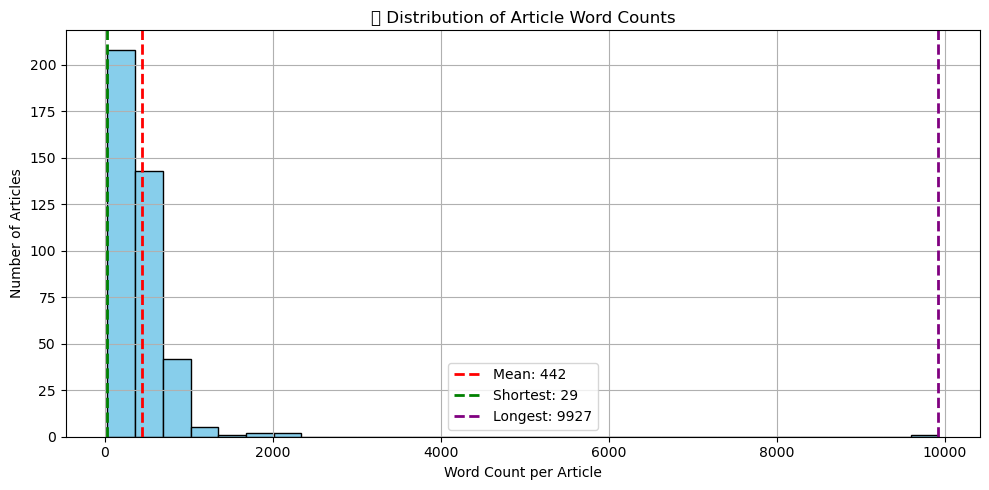

In [273]:

# Histogram
plt.figure(figsize=(10, 5))
plt.hist(word_counts, bins=30, color='skyblue', edgecolor='black')

plt.axvline(mean_words, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {int(mean_words)}')
plt.axvline(word_counts[min_idx], color='green', linestyle='dashed', linewidth=2, label=f'Shortest: {word_counts[min_idx]}')
plt.axvline(word_counts[max_idx], color='purple', linestyle='dashed', linewidth=2, label=f'Longest: {word_counts[max_idx]}')

plt.xlabel("Word Count per Article")
plt.ylabel("Number of Articles")
plt.title(" Distribution of Article Word Counts")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\shri\AppData\Local\Temp\ipykernel_27628\1948178266.py:10: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\shri\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


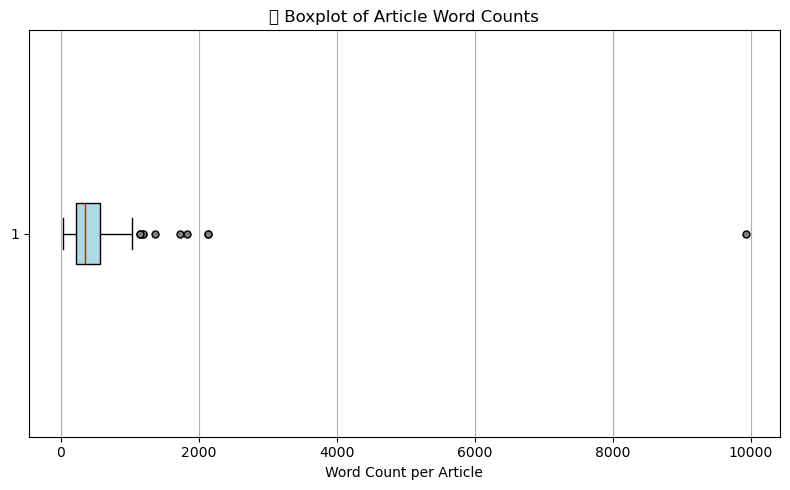

In [274]:
plt.figure(figsize=(8, 5))
plt.boxplot(word_counts, vert=False, patch_artist=True,
            boxprops=dict(facecolor='lightblue'),
            medianprops=dict(color='red'),
            flierprops=dict(marker='o', markerfacecolor='gray', markersize=5, linestyle='none'))

plt.xlabel("Word Count per Article")
plt.title("Boxplot of Article Word Counts")
plt.grid(axis='x')
plt.tight_layout()
plt.show()

We can see that very few articles have length above than 1500. Let's see the longest one and if is a genuine article.

In [275]:
longest_article['text']

"In its regular package of infringement decisions, the European Commission takes legal action against Member States that fail to comply with their obligations under EU law. These decisions, covering various EU policy areas, aim to ensure the proper application of EU law for the benefit of citizens and businesses. The key decisions taken by the Commission are presented below and grouped by policy area. The Commission is also closing 112 cases where the issues with the Member States concerned have been solved. In these cases, the Commission does not have to pursue the infringement procedure further. The Commission's enforcement activities and Member States' compliance with EU law can be followed throughinteractive maps and customisable graphs. For more details on the history of a case or to access the full database of infringement decisions, theinfringement decisions' registeris open for consultation. And more information on the EU infringement procedure can be found in the followingQ&A.

seems genuine

when I see the smallest one, the article has a table which we were not able to scrape because we only scraped the paragraphs.

In [279]:
print(f"2th percentile: {word_counts.quantile(0.02)}")

2th percentile: 68.0


In [302]:
sorted_indices = word_counts.sort_values().index
second_smallest_idx = sorted_indices[1]  # index 0 is the smallest
second_shortest_article = metadata_2.loc[second_smallest_idx]


In [305]:
second_shortest_article['url']

'https://commission.europa.eu/news-and-media/news/results-02-07-2025-auction-eu-bills-2025-07-02_en'

It seems that I have made a mistake. I only extracted text form P tags but few articles also contained table fromt them the data slippes so I am acrapping all the sites once again but this time I will extract text from all tags like P tag li tag tr tag

In [298]:
metadata_2.shape[0]

404

In [306]:
second_smallest_idx

142

In [300]:
text_with_tables = []

options = Options()
options.add_argument("--headless")
options.add_argument("--disable-gpu")
options.add_argument("--no-sandbox")

driver = webdriver.Chrome(options=options)

for i in tqdm(range(metadata_2.shape[0])):
    url = metadata_2['url'][i]
    try:
        driver.get(url)
        time.sleep(3)  

        soup = BeautifulSoup(driver.page_source, "html.parser")

        elements = soup.find_all(['p', 'li', 'td', 'th'])

        text = "\n".join(el.get_text(strip=True) for el in elements)

        text_with_tables.append(text)

    except Exception as e:
        print(f" Error fetching {url}: {e}")
        text_with_tables.append("")  

driver.quit()


100%|████████████████████████████████████████████████████████████████████████████████| 404/404 [23:01<00:00,  3.42s/it]


In [310]:
text_with_tables[5]

"This site uses cookies. Visit ourcookies policy pageor click the link in any footer for more information and to change your preferences.\nAll official European Union website addresses are in theeuropa.eudomain.\nSee all EU institutions and bodies\nbgбългарски\nesespañol\ncsčeština\ndadansk\ndeDeutsch\neteesti\nelελληνικά\nenEnglish\nfrfrançais\ngaGaeilge\nhrhrvatski\nititaliano\nlvlatviešu\nltlietuvių\nhumagyar\nmtMalti\nnlNederlands\nplpolski\nptportuguês\nroromână\nskslovenčina\nslslovenščina\nfisuomi\nsvsvenska\nukyкраїнська\nHome\nUkraineEU-Ukraine Solidarity LanesInformation for people fleeing the war in UkraineSee all\nEU-Ukraine Solidarity Lanes\nInformation for people fleeing the war in Ukraine\nSee all\nTransport modesAirRoadRailMaritimeInland waterwaysSee all\nAir\nRoad\nRail\nMaritime\nInland waterways\nSee all\nTransport themesMilitary mobilityMobility StrategyPassenger rightsSecurity & SafetyClean transportUrban transportSustainable transportInfrastructure and InvestmentS

In [314]:
metadata_2['text'][5]

"TheEuropean Union Aviation Safety Agency(EASA) andAir France-KLMhave signed an agreementto launch the airline group's preparations to partner on theEU Flight Emissions Label (FEL). This new Memorandum of Cooperation allows Air France and KLM to test the FEL scheme and receive reliable information from EASA about their flight emissions data before officially applying to participate in FEL underRegulation (EU) 2024/3170. This agreement marks a major advance in making the Flight Emissions Label more widely available. Launched in December 2024, FEL will set out areliableandharmonised methodologyfor estimating flight emissions, considering operational factors likeaircraft type,passenger numbersandfreight volumeon board, as well as the amount and type ofaviation fuelsuplifted per airport. It will also help passengers make more informed decisions when comparing and booking flights among competitors and protect them from misleading greenwashing claims. Ultimately, this initiative will strengt

In [315]:
metadata_2['url'][5]

'https://transport.ec.europa.eu/news-events/news/eu-flight-emissions-label-takes-flight-forward-first-airlines-committing-scheme-2025-07-11_en'

In [316]:
metadata_2['url'][142]

'https://commission.europa.eu/news-and-media/news/results-02-07-2025-auction-eu-bills-2025-07-02_en'

metadata_2['text'][0]

In [312]:
texts_2 = text_with_tables
starts = [text[:200] for text in texts_2]
ends = [text[-50:] for text in texts_2]

start_counts = Counter(starts)
end_counts = Counter(ends)

print("🔹 Most common starting phrases:")
for s, c in start_counts.most_common(5):
    print(f"({c} times)\n{s}\n")

print("\n🔹 Most common ending phrases:")
for e, c in end_counts.most_common(5):
    print(f"({c} times)\n{e}\n")

🔹 Most common starting phrases:
(343 times)
This site uses cookies. Visit ourcookies policy pageor click the link in any footer for more information and to change your preferences.
All official European Union website addresses are in theeuropa.

(40 times)
All official European Union website addresses are in theeuropa.eudomain.
See all EU institutions and bodies
This site uses cookies. Visit ourcookies policy pageor click the link in any footer for more

(4 times)
Skip to Content
All official European Union website addresses are in theeuropa.eudomain.
See all EU institutions and bodies
This site uses cookies. Visit ourcookies policy pageor click the link in any

(4 times)
All official European Union website addresses are in theeuropa.eudomain.
Topics
Analysis and data
Countries
Newsroom
About us
Press releasePublished 20 Jun 2025

Newsroom
Press releases
Europe’s bathi

(2 times)
All official European Union website addresses are in theeuropa.eudomain.
Topics
Analysis and data
Countries

In [325]:
text_with_tables_2 = []

options = Options()
options.add_argument("--headless")
options.add_argument("--disable-gpu")
options.add_argument("--no-sandbox")

driver = webdriver.Chrome(options=options)

#  Looping through the first 10 URLs only
for i in tqdm(range(metadata_2.shape[0])):
    url = metadata_2['url'][i]
    try:
        driver.get(url)
        time.sleep(3) 

 
        soup = BeautifulSoup(driver.page_source, "html.parser")

        main_divs = soup.find_all("div", class_="ecl")

        content = []
        for div in main_divs:
            elements = div.find_all(['p', 'li', 'td', 'th'])
            for el in elements:
                text = el.get_text(strip=True)
                if text:
                    content.append(text)

        #  Store joined content
        full_text = "\n".join(content)
        text_with_tables_2.append(full_text)

    except Exception as e:
        print(f" Error fetching {url}: {e}")
        text_with_tables_2.append("")  

driver.quit()

100%|████████████████████████████████████████████████████████████████████████████████| 404/404 [24:43<00:00,  3.67s/it]


In [318]:
text_with_tables[5]

"This site uses cookies. Visit ourcookies policy pageor click the link in any footer for more information and to change your preferences.\nAll official European Union website addresses are in theeuropa.eudomain.\nSee all EU institutions and bodies\nbgбългарски\nesespañol\ncsčeština\ndadansk\ndeDeutsch\neteesti\nelελληνικά\nenEnglish\nfrfrançais\ngaGaeilge\nhrhrvatski\nititaliano\nlvlatviešu\nltlietuvių\nhumagyar\nmtMalti\nnlNederlands\nplpolski\nptportuguês\nroromână\nskslovenčina\nslslovenščina\nfisuomi\nsvsvenska\nukyкраїнська\nHome\nUkraineEU-Ukraine Solidarity LanesInformation for people fleeing the war in UkraineSee all\nEU-Ukraine Solidarity Lanes\nInformation for people fleeing the war in Ukraine\nSee all\nTransport modesAirRoadRailMaritimeInland waterwaysSee all\nAir\nRoad\nRail\nMaritime\nInland waterways\nSee all\nTransport themesMilitary mobilityMobility StrategyPassenger rightsSecurity & SafetyClean transportUrban transportSustainable transportInfrastructure and InvestmentS

In [326]:
text_with_tables_2[5]

"TheEuropean Union Aviation Safety Agency(EASA) andAir France-KLMhave signed an agreementto launch the airline group's preparations to partner on theEU Flight Emissions Label (FEL). This new Memorandum of Cooperation allows Air France and KLM to test the FEL scheme and receive reliable information from EASA about their flight emissions data before officially applying to participate in FEL underRegulation (EU) 2024/3170.\nThis agreement marks a major advance in making the Flight Emissions Label more widely available. Launched in December 2024, FEL will set out areliableandharmonised methodologyfor estimating flight emissions, considering operational factors likeaircraft type,passenger numbersandfreight volumeon board, as well as the amount and type ofaviation fuelsuplifted per airport. It will also help passengers make more informed decisions when comparing and booking flights among competitors and protect them from misleading greenwashing claims. Ultimately, this initiative will streng

In [327]:
text_with_tables[142]

"This site uses cookies. Visit ourcookies policy pageor click the link in any footer for more information and to change your preferences.\nAll official European Union website addresses are in theeuropa.eudomain.\nSee all EU institutions and bodies\nbgбългарски\nesespañol\ncsčeština\ndadansk\ndeDeutsch\neteesti\nelελληνικά\nenEnglish\nfrfrançais\ngaGaeilge\nhrhrvatski\nititaliano\nlvlatviešu\nltlietuvių\nhumagyar\nmtMalti\nnlNederlands\nplpolski\nptportuguês\nroromână\nskslovenčina\nslslovenščina\nfisuomi\nsvsvenska\nHome\nAbout usAbout usLearn more about the role of the European Commission, its leadership and corporate policiesOrganisationPresidentCommissionersDepartments and executive agenciesStaffSee allRoleIn strategy and policyIn lawIn budget and fundingIn international relationsSee allService standards and principlesTransparencyEthics and Good AdministrationModernising the European CommissionThe Commission’s use of languagesSee allContactDiscover moreFEATURED2024-2029 Commission: 

In [328]:
text_with_tables_2[142]

'The European Commission, on behalf of the European Union, has today carried out an EU-Bills auction. The results of this auction are as follows:\nEU-Bills\nEU-Bills\nEU-Bills\nISIN\nEU000A4D85M6\nEU000A3L7AT2\nEU000A4EDCQ2\nDate of auction\n02/07/2025\n02/07/2025\n02/07/2025\nSettlement date\n04/07/2025\n04/07/2025\n04/07/2025\nMaturity\n03/10/2025\n09/01/2026\n03/07/2026\nVolume bids *\n1466\n2594\n4079\nVolume allotment *\n841\n997\n1398\nOld outstanding amount *\n2290\n2399\n0\nNew outstanding amount *\n3131\n3396\n1398\nWeighted average yield\n1.922%\n1.930%\n1.920%\nHighest accepted yield\n1.935%\n1.940%\n1.935%\n% awarded at highest accepted yield\n100%\n100%\n51.85%\nCover ratio\n1.74\n2.60\n2.92\n* in millions of euros'

I noticed that when tables are scraped they have a different structure separated by \n. So I tried to generate several questions by takin ss of the real table from the site. WHen i passed those question with scraped structure as context the mistral was able to answer the questionhs correctly. That means the mistral LLM model was able to translate the scraoped structure into table internally. So I am not changing anythin in the structure of the scraped texts. I will not split thenm into chuncks as it is.

In [339]:
text_with_tables_2[142]

'The European Commission, on behalf of the European Union, has today carried out an EU-Bills auction. The results of this auction are as follows:\nEU-Bills\nEU-Bills\nEU-Bills\nISIN\nEU000A4D85M6\nEU000A3L7AT2\nEU000A4EDCQ2\nDate of auction\n02/07/2025\n02/07/2025\n02/07/2025\nSettlement date\n04/07/2025\n04/07/2025\n04/07/2025\nMaturity\n03/10/2025\n09/01/2026\n03/07/2026\nVolume bids *\n1466\n2594\n4079\nVolume allotment *\n841\n997\n1398\nOld outstanding amount *\n2290\n2399\n0\nNew outstanding amount *\n3131\n3396\n1398\nWeighted average yield\n1.922%\n1.930%\n1.920%\nHighest accepted yield\n1.935%\n1.940%\n1.935%\n% awarded at highest accepted yield\n100%\n100%\n51.85%\nCover ratio\n1.74\n2.60\n2.92\n* in millions of euros'

this also does not contain any rubbish like coockies information and all so no need to remove the common sentances

I will replace the earlier text column with this text

In [331]:
metadata_2.head()

,title,url,date,text
0,Microfinance in Europe: Survey report 2024,https://social-economy-gateway.ec.europa.eu/mi...,2025-07-14,The European Microfinance Network (EMN) and th...
1,AccessibleEU surpassed all its objectives last...,https://accessible-eu-centre.ec.europa.eu/cont...,2025-07-14,This report provides a comprehensive overview ...
2,EU invests 2.8 billion in 94 transport project...,https://urban-mobility-observatory.transport.e...,2025-07-11,"On the 3 July 2025, the European Commission an..."
3,Hamburg deploys AI to boost efficiency of elec...,https://urban-mobility-observatory.transport.e...,2025-07-11,"Hadag, the operator of Hamburg’s ferry service..."
4,Israel/Palestine: Statement by the High Repres...,https://north-africa-middle-east-gulf.ec.europ...,2025-07-11,Following the Israeli Cabinet’s resolutions an...


In [332]:
metadata_2['text'] = text_with_tables_2

In [334]:
metadata_2.to_csv("cleaned_text_with_tables.csv" , index = False)

In [335]:
word_counts = []
word_counts = metadata_2['text'].apply(lambda x: len(str(x).split()))
mean_words = word_counts.mean()
min_idx = word_counts.idxmin()
max_idx = word_counts.idxmax()

shortest_article = metadata_2.loc[min_idx]
longest_article = metadata_2.loc[max_idx]

C:\Users\shri\AppData\Local\Temp\ipykernel_27628\1910769456.py:16: UserWarning: Glyph 128218 (\N{BOOKS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\shri\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128218 (\N{BOOKS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


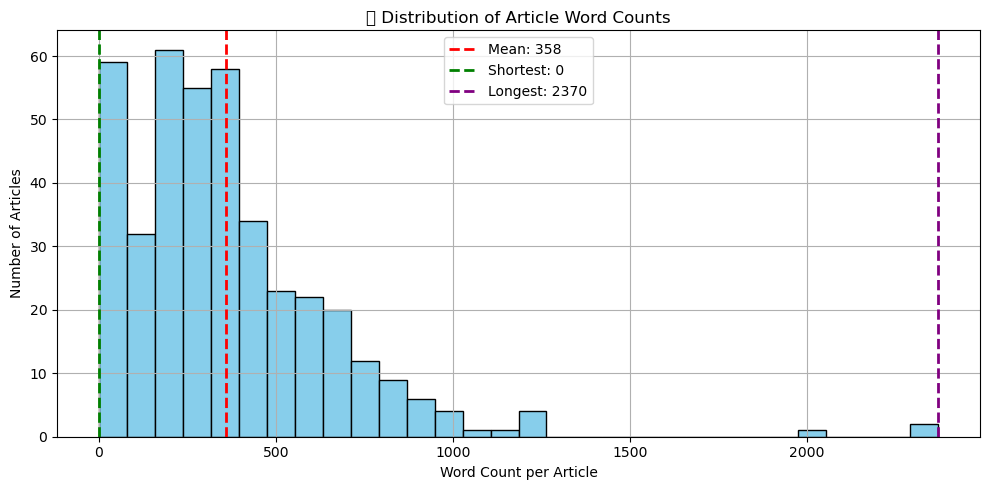

In [336]:

plt.figure(figsize=(10, 5))
plt.hist(word_counts, bins=30, color='skyblue', edgecolor='black')

plt.axvline(mean_words, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {int(mean_words)}')
plt.axvline(word_counts[min_idx], color='green', linestyle='dashed', linewidth=2, label=f'Shortest: {word_counts[min_idx]}')
plt.axvline(word_counts[max_idx], color='purple', linestyle='dashed', linewidth=2, label=f'Longest: {word_counts[max_idx]}')

plt.xlabel("Word Count per Article")
plt.ylabel("Number of Articles")
plt.title(" Distribution of Article Word Counts")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


lets see which has zero

In [359]:
num_empty_rows = metadata_2['text'].apply(lambda x: len(str(x).strip()) == 0).sum()
print(f"Number of rows with empty 'text': {num_empty_rows}")

Number of rows with empty 'text': 57


In [372]:
sorted_indices = word_counts.sort_values().index
second_smallest_idx = sorted_indices[58] 
second_shortest_article = metadata_2.loc[second_smallest_idx]


In [373]:
second_smallest_idx

127

In [374]:
second_shortest_article['url']

'https://civil-protection-humanitarian-aid.ec.europa.eu/news-stories/news/analysis-risks-europe-facing-2025-07-03_en'

In [375]:
second_shortest_article['text']

'The EU Joint Research Centre published a new report ‘Analysis of Risks Europe is facing’ about the complex and evolving risk landscape in Europe, shaped by climate change, geopolitical tensions and technological advances. Scientists analysed 47 risks - natural and human-induced - that pose a threat to people, infrastructure, economies, and the overall stability of the EU.\nFor more information visit:JRC Publications Repository - Analysis of Risks Europe is facing'

I discovered that some of the pages I scraped don’t contain the div tag with the ecl class, which is why their extracted content length is zero. I could scrape these pages separately and then merge the results into the final table, but I’m wondering if that’s the right approach. Is there a single, more consistent method to extract all relevant data from every page?

Next time to scrape all the texts form pages try below code.

In [377]:
# def extract_content(soup):
#     # 1. Try to extract from ecl content blocks
#     ecl_divs = soup.select("div[class^='ecl']")
#     if ecl_divs:
#         elements = []
#         for div in ecl_divs:
#             elements.extend(div.find_all(['p', 'li', 'td', 'th']))
#         text = "\n".join(el.get_text(strip=True) for el in elements)
#         if text.strip():  # Only return if there's useful content
#             return text

#     # 2. Fallback: extract from whole page (as broad catch-all)
#     fallback_elements = soup.find_all(['p', 'li', 'td', 'th'])
#     return "\n".join(el.get_text(strip=True) for el in fallback_elements)


# text = extract_content(soup)
# text_with_tables[i] = text


For now, I am just scrapping the pages for which the length of the text is zero and replacing them correspondingly.

In [378]:
empty_indices = metadata_2[metadata_2['text'].apply(lambda x: len(str(x).strip()) == 0)].index

# Dictionary to store rescraped content: {index: text}
rescraped_text = {}

options = Options()
options.add_argument("--headless")
options.add_argument("--disable-gpu")
options.add_argument("--no-sandbox")
driver = webdriver.Chrome(options=options)

for i in tqdm(empty_indices, desc="Rescraping empty rows"):
    url = metadata_2.loc[i, 'url']
    try:
        driver.get(url)
        time.sleep(3)  

        soup = BeautifulSoup(driver.page_source, "html.parser")

        elements = soup.find_all(['p', 'li', 'td', 'th'])
        text = "\n".join(el.get_text(strip=True) for el in elements)

        rescraped_text[i] = text

    except Exception as e:
        print(f" Error fetching {url}: {e}")
        rescraped_text[i] = ""  # Track even failed attempts

driver.quit()

Rescraping empty rows: 100%|███████████████████████████████████████████████████████████| 57/57 [03:57<00:00,  4.16s/it]


In [386]:
rescraped_text[44]

"All official European Union website addresses are in theeuropa.eudomain.\nSee all EU institutions and bodies\nThis site uses cookies. Visit ourcookies policy pageor click the link in any footer for more information and to change your preferences.\nbgбългарски\ncsčeština\ndadansk\ndeDeutsch\nelΕλληνικά\nenEnglish\nesespañol\neteesti\nfisuomi\nfrfrançais\ngaGaeilge\nhrhrvatski\nhuMagyar\nitItaliano\nltlietuvių kalba\nlvlatviešu valoda\nmtMalti\nnlNederlands\nplpolski\nptPortuguês\nroromână\nskslovenčina\nslslovenščina\nsvsvenska\n...\n\nThe European Commission has issued informal guidance on the compatibility with EU competition rules of a sustainability agreement for the joint purchasing and the setting of technical specifications for electric container-handling equipment usedin ports. This would accelerate the shift from diesel to electric equipment in EU ports, contributing to reducing CO2 emissions.\nThis informal guidance letter is issued at the same time asanother one regarding a 

In [382]:
metadata_2['url'][23]

'https://policy.trade.ec.europa.eu/news/call-tender-assessment-effectiveness-trade-defense-instruments-tdi-measures-2025-07-10_en'

In [390]:
empty_texts_scrapped = list(rescraped_text.values())

In [399]:
empty_texts_scrapped[10]

"All official European Union website addresses are in theeuropa.eudomain.\nSee all EU institutions and bodies\nThis site uses cookies. Visit ourcookies policy pageor click the link in any footer for more information and to change your preferences.\nbgбългарски\ncsčeština\ndadansk\ndeDeutsch\nelΕλληνικά\nenEnglish\nesespañol\neteesti\nfisuomi\nfrfrançais\ngaGaeilge\nhrhrvatski\nhuMagyar\nitItaliano\nltlietuvių kalba\nlvlatviešu valoda\nmtMalti\nnlNederlands\nplpolski\nptPortuguês\nroromână\nskslovenčina\nslslovenščina\nsvsvenska\n...\n\nThe European Commission is launching today aCall for Evidence and a public consultationinviting stakeholders to give feedback on the future of the EU procedures for the application of EU competition rules. Based on the results of the evaluation, completed in September 2024 with the publication of aStaff Working Document, the Commission has decided to launch the process for revising the relevant rules, notably with the aim of keeping up with transformativ

In [400]:
empty_texts_scrapped[0]

"This site uses cookies. Visit ourcookies policy pageor click the link in any footer for more information and to change your preferences.\nAn official website of the European Union\nAll official European Union website addresses are in theeuropa.eudomain.\nSee all EU institutions and bodies\nYou are signed out of the TED application, but you 're still logged in to EU Login. If you wish to logout of EU Login, please clickhere\nThis site is managed by:Publications Office of the European Union\nHelp\nContact the TED helpdesk\nX/Twitter\nYouTube\nLegal notice\nCookies\nAccessibility\nAbout TED\nSite map\nEU law\nEuropean Data\nEU research results\nEU Whoiswho\nEU Publications\nDiscover more oneuropa.eu\nCall us 00 800 6 7 8 9 10 11\nUse other telephone options\nWrite to us via our contact form\nMeet us at one of the EU centres\nSearch for EU social media channels\nLanguages on our websites\nPrivacy policy\nLegal notice\nCookies\nSearch for EU social media channels\nSearch all EU institution

In [394]:
texts_2 = empty_texts_scrapped
starts = [text[:200] for text in texts_2]
ends = [text[-50:] for text in texts_2]

start_counts = Counter(starts)
end_counts = Counter(ends)

print("🔹 Most common starting phrases:")
for s, c in start_counts.most_common(5):
    print(f"({c} times)\n{s}\n")

print("\n🔹 Most common ending phrases:")
for e, c in end_counts.most_common(5):
    print(f"({c} times)\n{e}\n")

🔹 Most common starting phrases:
(38 times)
All official European Union website addresses are in theeuropa.eudomain.
See all EU institutions and bodies
This site uses cookies. Visit ourcookies policy pageor click the link in any footer for more

(4 times)
Skip to Content
All official European Union website addresses are in theeuropa.eudomain.
See all EU institutions and bodies
This site uses cookies. Visit ourcookies policy pageor click the link in any

(4 times)
All official European Union website addresses are in theeuropa.eudomain.
Topics
Analysis and data
Countries
Newsroom
About us
Press releasePublished 20 Jun 2025

Newsroom
Press releases
Europe’s bathi

(2 times)
All official European Union website addresses are in theeuropa.eudomain.
Topics
Analysis and data
Countries
Newsroom
About us
Press releasePublished 26 Jun 2025

Newsroom
Press releases
Renewables and

(2 times)
All official European Union website addresses are in theeuropa.eudomain.
Topics
Analysis and data
Countries
N

In [403]:
boilerplate_sentences = [
    "This site uses cookies.",
    "Visit ourcookies policy pageor click the link in any footer for more information and to change your preferences.",
    "All official European Union website addresses are in theeuropa.eudomain.",
    "See all EU institutions and bodies",
    "Share this page",
    "Follow us",
    "Follow the European Commission",
    "Data Protection",
    "Legal notice",
    "Privacy policy",
    "Cookies"
    
]
clean_empty_texts_scrapped = {
    idx: clean_sentences(txt) for idx, txt in rescraped_text.items()
}

In [405]:
x = list(clean_empty_texts_scrapped.values())

In [408]:
empty_texts_scrapped[1]

"All official European Union website addresses are in theeuropa.eudomain.\nSee all EU institutions and bodies\nThis site uses cookies. Visit ourcookies policy pageor click the link in any footer for more information and to change your preferences.\nbgбългарски\ncsčeština\ndadansk\ndeDeutsch\nelΕλληνικά\nenEnglish\nesespañol\neteesti\nfisuomi\nfrfrançais\ngaGaeilge\nhrhrvatski\nhuMagyar\nitItaliano\nltlietuvių kalba\nlvlatviešu valoda\nmtMalti\nnlNederlands\nplpolski\nptPortuguês\nroromână\nskslovenčina\nslslovenščina\nsvsvenska\n...\n\nThe European Commission is launching today aCall for Evidence and a public consultationinviting stakeholders to give feedback on the future of the EU procedures for the application of EU competition rules. Based on the results of the evaluation, completed in September 2024 with the publication of aStaff Working Document, the Commission has decided to launch the process for revising the relevant rules, notably with the aim of keeping up with transformativ

In [409]:
x[1]

"bgбългарски csčeština dadansk deDeutsch elΕλληνικά enEnglish esespañol eteesti fisuomi frfrançais gaGaeilge hrhrvatski huMagyar itItaliano ltlietuvių kalba lvlatviešu valoda mtMalti nlNederlands plpolski ptPortuguês roromână skslovenčina slslovenščina svsvenska ... The European Commission is launching today aCall for Evidence and a public consultationinviting stakeholders to give feedback on the future of the EU procedures for the application of EU competition rules. Based on the results of the evaluation, completed in September 2024 with the publication of aStaff Working Document, the Commission has decided to launch the process for revising the relevant rules, notably with the aim of keeping up with transformative changes such as digitalisation of the economy. All interested stakeholders can express their views by 2 October 2025. Need for a revision On5 September 2024, the Commission published a Staff Working Document summarising the findings of the evaluation ofRegulation 1/2003and

That is enough, let's put them into the metadata_2['text'] .

In [410]:
for idx, cleaned_text in clean_empty_texts_scrapped.items():
    metadata_2.at[idx, 'text'] = cleaned_text


C:\Users\shri\AppData\Local\Temp\ipykernel_27628\1675924899.py:30: UserWarning: Glyph 128218 (\N{BOOKS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\shri\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128218 (\N{BOOKS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


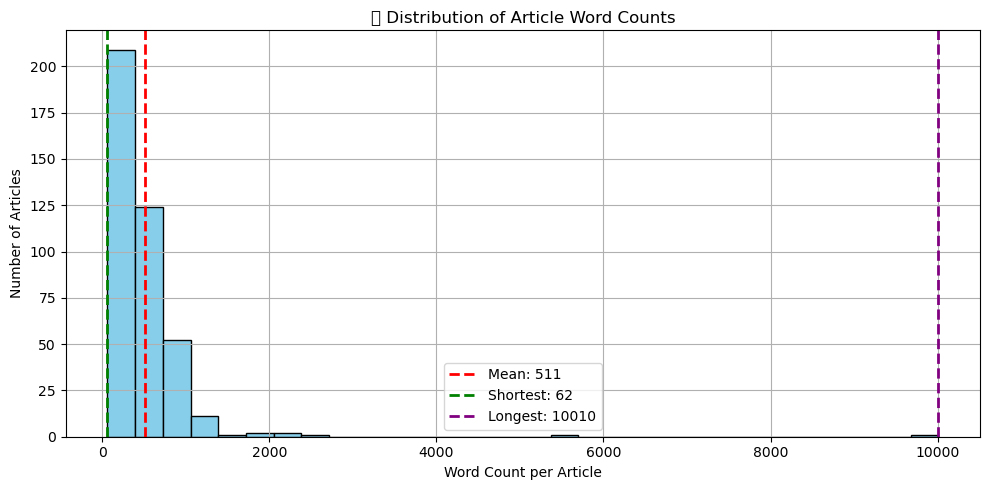

In [411]:
word_counts = []
word_counts = metadata_2['text'].apply(lambda x: len(str(x).split()))
mean_words = word_counts.mean()
min_idx = word_counts.idxmin()
max_idx = word_counts.idxmax()

shortest_article = metadata_2.loc[min_idx]
longest_article = metadata_2.loc[max_idx]
plt.figure(figsize=(10, 5))
plt.hist(word_counts, bins=30, color='skyblue', edgecolor='black')
plt.axvline(mean_words, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {int(mean_words)}')
plt.axvline(word_counts[min_idx], color='green', linestyle='dashed', linewidth=2, label=f'Shortest: {word_counts[min_idx]}')
plt.axvline(word_counts[max_idx], color='purple', linestyle='dashed', linewidth=2, label=f'Longest: {word_counts[max_idx]}')

plt.xlabel("Word Count per Article")
plt.ylabel("Number of Articles")
plt.title(" Distribution of Article Word Counts")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [412]:
metadata_2.to_csv("cleaned_text_with_tables.csv" ,  index = False)

In [420]:
texts_2 = metadata_2['text']
starts = [text[:250] for text in texts_2]
ends = [text[-400:] for text in texts_2]
start_counts = Counter(starts)
end_counts = Counter(ends)

print("🔹 Most common starting phrases:")
for s, c in start_counts.most_common(5):
    print(f"({c} times)\n{s}\n")

print("\n🔹 Most common ending phrases:")
for e, c in end_counts.most_common(5):
    print(f"({c} times)\n{e}\n")

🔹 Most common starting phrases:
(37 times)
bgбългарски csčeština dadansk deDeutsch elΕλληνικά enEnglish esespañol eteesti fisuomi frfrançais gaGaeilge hrhrvatski huMagyar itItaliano ltlietuvių kalba lvlatviešu valoda mtMalti nlNederlands plpolski ptPortuguês roromână skslovenčina slslovenščin

(4 times)
On 18 June, the EU Anti-Trafficking Coordinator, Diane Schmitt, and the Inter-Agency Coordination Group against Trafficking in Persons (ICAT), which was mandated by the UN General Assembly, discussed emerging trends, challenges, and priorities in a m

(4 times)
The European Commission has launched apublic consultation on rules for calculating, verifying and reporting recycled content in single-use plastic (SUP) beverage bottles, includingchemically-recycled content.
The adoption of the rules will enable che

(4 times)
The rule of law is the cornerstone of our democracies. It is also integral for the future of our economies and for Europe’s security. In its latestannual Rule of Law repor

In [425]:

# Lists of phrases to remove
starting_phrases = [
    "български čeština dansk deDeutsch elΕλληνικά enEnglish esespañol eteesti fisuomi frfrançais gaGaeilge hrhrvatski huMagyar itItaliano ltlietuvių kaaz kz kk lvlatviešu valoda mtMalti nlNederlands plpolski ptPortuguês roromână skslovenčina slslovenščin",
]

ending_phrases = [
    "Press contacts in EU countries.*?",
    "EURES onX", "EURES onLinkedIn", "EURES onInstagram",
]


starting_regex = re.compile(r'^([\w\W]*?(?:slovenščina|svsenska).{0,50})', re.IGNORECASE | re.DOTALL)

ending_regex = re.compile(r'(' + '|'.join(ending_phrases) + r')$', re.IGNORECASE | re.DOTALL)
def clean_boilerplate(text):
    text = re.sub(starting_regex, '', text.strip())
    text = re.sub(ending_regex, '', text.strip())
    return text.strip()

#  Apply to all rows in metadata_2['text']
metadata_2['text'] = metadata_2['text'].apply(lambda x: clean_boilerplate(str(x)))


In [426]:
texts_2 = metadata_2['text']
starts = [text[:250] for text in texts_2]
ends = [text[-400:] for text in texts_2]
start_counts = Counter(starts)
end_counts = Counter(ends)

print("🔹 Most common starting phrases:")
for s, c in start_counts.most_common(5):
    print(f"({c} times)\n{s}\n")

print("\n🔹 Most common ending phrases:")
for e, c in end_counts.most_common(5):
    print(f"({c} times)\n{e}\n")

🔹 Most common starting phrases:
(4 times)
On 18 June, the EU Anti-Trafficking Coordinator, Diane Schmitt, and the Inter-Agency Coordination Group against Trafficking in Persons (ICAT), which was mandated by the UN General Assembly, discussed emerging trends, challenges, and priorities in a m

(4 times)
The European Commission has launched apublic consultation on rules for calculating, verifying and reporting recycled content in single-use plastic (SUP) beverage bottles, includingchemically-recycled content.
The adoption of the rules will enable che

(4 times)
The rule of law is the cornerstone of our democracies. It is also integral for the future of our economies and for Europe’s security. In its latestannual Rule of Law report, the European Commission examines rule of law developments in all EU countrie

(4 times)
Today, President Ursulavon der Leyenand European Council President AntónioCostawill travel to Chișinău for the first ever EU-Moldova Summit. Together with President of the 

In [429]:
metadata_2.to_csv("cleaned_text_with_tables.csv" ,  index = False)

In [430]:
duplicates = metadata_2[metadata_2.duplicated(keep=False)]

# Number of duplicate rows
num_duplicates = len(duplicates)

print(f"Number of duplicate rows: {num_duplicates}")
duplicates.head()

Number of duplicate rows: 146


,title,url,date,text
2,EU invests 2.8 billion in 94 transport project...,https://urban-mobility-observatory.transport.e...,2025-07-11,"On the 3 July 2025, the European Commission an..."
12,EU invests 2.8 billion in 94 transport project...,https://urban-mobility-observatory.transport.e...,2025-07-11,"On the 3 July 2025, the European Commission an..."
52,EU and UN cooperate on combatting trafficking ...,https://home-affairs.ec.europa.eu/news/eu-and-...,2025-07-08,"On 18 June, the EU Anti-Trafficking Coordinato..."
53,EU and UN cooperate on combatting trafficking ...,https://home-affairs.ec.europa.eu/news/eu-and-...,2025-07-08,"On 18 June, the EU Anti-Trafficking Coordinato..."
54,Plastic waste: Commission consults on new rule...,https://environment.ec.europa.eu/news/commissi...,2025-07-08,The European Commission has launched apublic c...


In [431]:
duplicates_text = metadata_2[metadata_2['text'].duplicated(keep=False)]

# Number of duplicates
print(f"Number of rows with duplicate 'text': {len(duplicates_text)}")
duplicates_text.head()

Number of rows with duplicate 'text': 149


,title,url,date,text
2,EU invests 2.8 billion in 94 transport project...,https://urban-mobility-observatory.transport.e...,2025-07-11,"On the 3 July 2025, the European Commission an..."
12,EU invests 2.8 billion in 94 transport project...,https://urban-mobility-observatory.transport.e...,2025-07-11,"On the 3 July 2025, the European Commission an..."
30,5 things you should know about extreme weather,https://energy.ec.europa.eu/news/5-things-you-...,2025-07-10,While no single extreme weather event can be b...
50,5 things you should know about extreme weather,https://climate.ec.europa.eu/news-other-reads/...,2025-07-09,While no single extreme weather event can be b...
52,EU and UN cooperate on combatting trafficking ...,https://home-affairs.ec.europa.eu/news/eu-and-...,2025-07-08,"On 18 June, the EU Anti-Trafficking Coordinato..."


In [435]:
print(metadata_2.loc[2, 'url'])
print(metadata_2.loc[12, 'url'])

https://urban-mobility-observatory.transport.ec.europa.eu/news-events/news/eu-invests-28-billion-94-transport-projects-boost-sustainable-and-connected-mobility-across-europe-2025-07-11_en
https://urban-mobility-observatory.transport.ec.europa.eu/news-events/news/eu-invests-28-billion-94-transport-projects-boost-sustainable-and-connected-mobility-across-europe-2025-07-11_en


In [436]:
duplicates_text = metadata[metadata['text'].astype(str).duplicated(keep=False)]

# Number of duplicates
print(f"Number of rows with duplicate 'text': {len(duplicates_text)}")

duplicates_text.head()

Number of rows with duplicate 'text': 83


,title,url,date,text
9,Announcement of next auction (EU-Bonds) on 14-...,https://commission.europa.eu/news-and-media/ne...,2025-07-09,[This site uses cookies. Visit ourcookies poli...
17,EU and UN cooperate on combatting trafficking ...,https://home-affairs.ec.europa.eu/news/eu-and-...,2025-07-08,[This site uses cookies. Visit ourcookies poli...
18,Plastic waste: Commission consults on new rule...,https://environment.ec.europa.eu/news/commissi...,2025-07-08,[This site uses cookies. Visit ourcookies poli...
19,Progress in rule of law in EU but further acti...,https://commission.europa.eu/news-and-media/ne...,2025-07-08,[This site uses cookies. Visit ourcookies poli...
27,EU and UN cooperate on combatting trafficking ...,https://home-affairs.ec.europa.eu/news/eu-and-...,2025-07-08,[This site uses cookies. Visit ourcookies poli...


In [437]:
metadata.shape

(351, 4)

In [438]:
metadata_3 = metadata_2.drop_duplicates(subset='url', keep='first')


In [439]:
metadata_3.shape

(317, 4)

In [440]:
metadata_3.to_csv("Final_metadata.csv" ,  index = False)

I analysed all the csv files, it seems that when we jump from one page to another page some articles are on multiple pages. That's why the content is present more than once. So, I have removed the duplicates and updated in "Final_metadata.csv" 

In [441]:
duplicates_text = metadata_3[metadata_3['url'].duplicated(keep=False)]

# Number of duplicates
print(f"Number of rows with duplicate 'text': {len(duplicates_text)}")
duplicates_text.head()

Number of rows with duplicate 'text': 0


,title,url,date,text


Now, I will move to the next part which is chunking and vectorisation

Creating a new Notebook for better understability. "Chunking&Vectorisation"